In [1]:
import pandas as pd
import requests
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import umap

/home/neal-kewalramani/.virtualenvs/cont-learn/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
from torch_geometric.data.batch import Batch
from torch_geometric.data import Data
from torch.utils.data import Dataset

In [3]:
torch.manual_seed(2809)

In [4]:
scRNA_data = pd.read_csv('GSE200981_scRNAseq_processed.tsv', sep='\t')
scRNA_data.index = scRNA_data['Gene.names']
scRNA_data = scRNA_data.drop('Gene.names', axis=1)
len(scRNA_data)

26364

In [5]:
#Mapping string to protein names
string_api_url = "https://string-db.org/api"
output_format = "tsv-no-header"
method = "get_string_ids"

params = {

    "identifiers" : "\r".join(list(scRNA_data.index)), # your protein list
    "limit": 1,
    "echo_query": 1,
    "species" : 9606, # species NCBI identifier 
    "caller_identity" : "www.awesome_app.org" # your app name

}

request_url = "/".join([string_api_url, output_format, method])

results = requests.post(request_url, data=params)


protein_2_string = dict()
string_2_protein = dict()

for line in results.text.strip().split("\n"):
    l = line.split("\t")
    protein_identifier, string_identifier = l[0], l[2]
    protein_2_string[protein_identifier] = string_identifier
    string_2_protein[string_identifier] = protein_identifier

In [6]:
scRNA_data = scRNA_data.loc[list(protein_2_string.keys())]
scRNA_data

,V1_T0,V2_T0,V3_T0,V4_T0,V5_T0,V6_T0,V7_T0,V8_T0,V9_T0,V10_T0,...,V247_T7,V248_T7,V249_T7,V250_T7,V251_T7,V252_T7,V253_T7,V254_T7,V255_T7,V256_T7
Gene.names,,,,,,,,,,,,,,,,,,,,,
OR4F5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F29,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OR4F16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SAMD11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAZ1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DAZ2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
import gc
torch.cuda.empty_cache()
gc.collect()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'

In [8]:
device

device(type='cuda')

In [9]:
def get_all_protein_pairs(protein_list):
    protein_pairs = []
    for i in range(len(protein_list)):
        protein1 = protein_list[i]
        for j in range(i+1, len(protein_list)):
            protein2 = protein_list[j]
        
            protein_pairs.append((protein1, protein2))
            
    return protein_pairs

class Contrastive_Dataset(Dataset):
    def __init__(self, scRNA_data, string_2_protein, batch_size):
        self.counter = 0
        self.e_counter = 0
        self.m_counter = 0
        self.batch_size = batch_size
        filename = '9606.protein.links.v12.0.txt'

        file = open(filename, 'r')
        lines = file.readlines()
        lines.pop(0)

        string_2_index = dict()
        counter = 0
        for string_id in string_2_protein:
            string_2_index[string_id] = counter
            counter += 1

        list_network = list()
        
        self.e_nodes = list()
        self.m_nodes = list()

        print('Getting network tensor...')
        for line in tqdm(lines):
            line = line.strip().split(' ')

            if int(line[2]) >= 999:

                try:
                    id1 = string_2_index[line[0]]
                    id2 = string_2_index[line[1]]
                    list_network.append([id1, id2])
                    list_network.append([id2, id1])

                except KeyError:
                    continue

        print('Getting node features tensor...')
        T0_column_vals = [column for column in scRNA_data.columns if 'T0' in column]
        T8_column_vals = [column for column in scRNA_data.columns if 'T7' in column]
        
        proteins = set([string_2_protein[string_id] for string_id in string_2_index])
        
        for column in T0_column_vals:   
            self.e_nodes.append(torch.tensor([scRNA_data.loc[protein, column] for protein in proteins], dtype=torch.float32).to(device))
                                        
        for column in T8_column_vals:
            self.m_nodes.append(torch.tensor([scRNA_data.loc[protein, column] for protein in proteins], dtype=torch.float32).to(device))
        
        self.edge_index = torch.tensor(list_network).t().contiguous()
        self.edge_index = self.edge_index.to(device)
        
        self.e_nodes = [i.view(len(i), 1) for i in self.e_nodes]
        self.m_nodes = [i.view(len(i), 1) for i in self.m_nodes]
    
    def __getitem__(self, idx):
        return self.e_nodes[idx], self.m_nodes[idx], self.edge_index
            
    def get_e_nodes(self):
        return self.e_nodes
    
    def get_m_nodes(self):
        return self.m_nodes#[0:10]
    
    def get_edge_index(self):
        return self.edge_index

    def shuffle(self):
        random.shuffle(self.e_nodes)
        random.shuffle(self.m_nodes)

    def __len__(self):
        return min(len(self.e_nodes), len(self.m_nodes))

In [10]:
def graph_collate_fn(batch):
    m_node_features = []
    e_node_features = []
    graph_list = []
    counter = 0
    batch_size = len(batch)
    
    for ex in batch:
        e_node, m_node, graph = ex
        num_nodes = e_node.shape[0]
        m_node_features.append(m_node)
        e_node_features.append(e_node)

    for i in range(batch_size):
        graph_list.append(graph + num_nodes*i)
    graphs_2 = graph_list[0:2]

    e_node_features = torch.stack(e_node_features, dim=0)
    e_node_features = torch.reshape(e_node_features, (e_node_features.shape[0]*e_node_features.shape[1], e_node_features.shape[2]))
    
    graphs = torch.cat(graph_list, 1)
    graphs_2 = torch.cat(graphs_2, 1)

    m_node_features = torch.stack(m_node_features, dim=0)
    m_node_features = torch.reshape(m_node_features, (m_node_features.shape[0]*m_node_features.shape[1], m_node_features.shape[2]))
    
    return e_node_features, m_node_features, graphs_2, graphs

In [11]:
batch_size = 20
contrastive_dataset = Contrastive_Dataset(scRNA_data, string_2_protein, batch_size)

Getting network tensor...


100%|██████████████████████████| 13715404/13715404 [00:05<00:00, 2598477.40it/s]


Getting node features tensor...


In [12]:
#contrastive_dataloader = DataLoader(contrastive_dataset, batch_size=batch_size, shuffle=True, collate_fn=graph_collate_fn)

In [13]:
def cosine_similarity(x1, x2, temp):
    return (torch.dot(x1.reshape(x1.shape[1]), x2.reshape(x2.shape[1]))/(torch.norm(x1)*torch.norm(x2)))/temp
    
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.temp = 1
    
    def forward(self, zn, zd):
        zi = zn[0, :, :]
        zj = zn[1, :, :].detach()
        num = torch.exp(cosine_similarity(zi, zj, self.temp))
        #print('Numerator')
        #print(num)

        #with torch.no_grad():
        denom = sum([torch.exp(cosine_similarity(zi, zd[i, :, :].detach(), self.temp)) for i in range(zd.shape[0])])
        #print('Denominator')
        #print(denom)
        return torch.multiply(torch.log(torch.divide(num, denom)), -1)

In [14]:
def train_model(epochs, dataset, gat, mlp, optimizer):
    torch.cuda.empty_cache()
    criterion = ContrastiveLoss()
    plot_losses = []
    for _ in tqdm(range(epochs)):
        dataset.shuffle()
        dataloader = DataLoader(dataset, batch_size=10, shuffle=False, collate_fn=graph_collate_fn)
        torch.cuda.empty_cache()
        
        for batch in dataloader:
            batch_losses = []
            e_nodes, m_nodes, graphs_2, graphs = batch
            batch_size = e_nodes.shape[0]//18840
            e_nodes_unstacked = torch.reshape(e_nodes, (batch_size, 1, -1))

            zd = gat(m_nodes, graphs)
            zd = mlp(zd)

            all_losses = []

            for i in range(e_nodes_unstacked.shape[0]):
                xi = e_nodes_unstacked[i]
                #print(xi)
                for j in range(e_nodes_unstacked.shape[0]):
                    if i == j: continue
                    xj = e_nodes_unstacked[j]
                    xn = torch.stack([xi, xj], dim=0)
                    xn = torch.reshape(xn, (xn.shape[0]*xn.shape[2], xn.shape[1]))
                    zn = gat(xn, graphs_2)
                    zn = mlp(zn)

                    loss = criterion(zn, zd)
                    #print(loss)
                    all_losses.append(loss)
                    
            #final_loss = sum(all_losses)/len(all_losses)
            #batch_losses.append(final_loss.item())
            #print(final_loss)
            #final_loss.backward()
            #optimizer.step()
            #final_loss.detach()

            m_nodes_unstacked = torch.reshape(m_nodes, (batch_size, 1, -1))

            zd = gat(e_nodes, graphs)
            zd = mlp(zd)

            #all_losses = []
            for i in range(m_nodes_unstacked.shape[0]):
                xi = m_nodes_unstacked[i]
                #print(xi)
                for j in range(m_nodes_unstacked.shape[0]):
                    if i == j: continue

                    xj = m_nodes_unstacked[j]
                    xn = torch.stack([xi, xj], dim=0)
                    xn = torch.reshape(xn, (xn.shape[0]*xn.shape[2], xn.shape[1]))
                    zn = gat(xn, graphs_2)
                    zn = mlp(zn)

                    loss = criterion(zn, zd)
                    all_losses.append(loss)
                    
            final_loss = sum(all_losses)/len(all_losses)
            batch_losses.append(final_loss.item())
            #print(final_loss)
            final_loss.backward()
            optimizer.step()
            #final_loss.detach()
        plot_losses.append(sum(batch_losses)/len(batch_losses)) 
        print(plot_losses)
    return plot_losses

In [15]:
class GAT_Contrast(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads):
        super().__init__()

        self.conv1 = GATConv(in_channels, hidden_channels, heads, dropout = 0.6)
        #self.conv2 = GATConv(hidden_channels*heads, out_channels, heads, dropout=0.6)
        self.num_nodes = 18840
        self.output_layer = nn.Linear(self.num_nodes*hidden_channels*heads, out_channels)
        #self.columns = out_channels*heads

    def forward(self, x, edge_index):
        batch_size = x.shape[0]//self.num_nodes
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = torch.reshape(x, (batch_size, 1, -1))

        x = self.output_layer(x)
        x = F.relu(x)
        return x

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.linear1 = nn.Linear(in_channels, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, out_channels)
        self.num_nodes = 18840

    def forward(self, x):
        #batch_size = x.shape[0]//self.num_nodes
        #x = torch.reshape(x, (batch_size, 1, -1))
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        return x

In [16]:
import torch_geometric.utils
from torch_geometric.nn import GATConv

def GAT_contrast_train(gat, mlp, dataset, epochs, num_nodes, lr = 1e-6, weight_decay = 5e-4, temp=0.05):
    torch.cuda.empty_cache()
    params = list(gat.parameters()) + list(mlp.parameters())
    optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    criterion = ContrastiveLoss()
    gat.train()
    mlp.train()
    optimizer.zero_grad()

    losses = train_model(epochs, dataset, gat, mlp, optimizer)
    return losses

In [17]:
#Need to put in tensor batches again
gat_contrast = GAT_Contrast(1, 8, 64, 2).to(device)
mlp_contrast = MLP(64, 32, 16).to(device)
#gat_contrast = torch.load('gat_contrast.pt', weights_only=False)
#mlp_contrast = torch.load('mlp_contrast.pt', weights_only=False)

In [18]:
losses = GAT_contrast_train(gat_contrast, mlp_contrast, contrastive_dataset, 100, scRNA_data.shape[0])

  1%|▍                                          | 1/100 [00:21<35:14, 21.36s/it]

[1.6534733772277832]


  2%|▊                                          | 2/100 [00:42<34:46, 21.29s/it]

[1.6534733772277832, 1.4758497476577759]


  3%|█▎                                         | 3/100 [01:03<34:23, 21.27s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943]


  4%|█▋                                         | 4/100 [01:25<34:01, 21.27s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868]


  5%|██▏                                        | 5/100 [01:46<33:40, 21.27s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334]


  6%|██▌                                        | 6/100 [02:07<33:15, 21.23s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596]


  7%|███                                        | 7/100 [02:28<32:52, 21.21s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486]


  8%|███▍                                       | 8/100 [02:49<32:31, 21.21s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754]


  9%|███▊                                       | 9/100 [03:11<32:20, 21.33s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584]


 10%|████▏                                     | 10/100 [03:33<32:05, 21.39s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912]


 11%|████▌                                     | 11/100 [03:54<31:45, 21.41s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127]


 12%|█████                                     | 12/100 [04:15<31:23, 21.40s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385]


 13%|█████▍                                    | 13/100 [04:37<31:04, 21.43s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357]


 14%|█████▉                                    | 14/100 [04:58<30:46, 21.47s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512]


 15%|██████▎                                   | 15/100 [05:20<30:26, 21.49s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401]


 16%|██████▋                                   | 16/100 [05:42<30:06, 21.51s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563]


 17%|███████▏                                  | 17/100 [06:03<29:46, 21.52s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404]


 18%|███████▌                                  | 18/100 [06:24<29:17, 21.43s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754]


 19%|███████▉                                  | 19/100 [06:46<28:51, 21.37s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471]


 20%|████████▍                                 | 20/100 [07:07<28:33, 21.41s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294]


 21%|████████▊                                 | 21/100 [07:29<28:13, 21.44s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335]


 22%|█████████▏                                | 22/100 [07:50<27:54, 21.47s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427]


 23%|█████████▋                                | 23/100 [08:12<27:34, 21.48s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079]


 24%|██████████                                | 24/100 [08:33<27:19, 21.57s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359]


 25%|██████████▌                               | 25/100 [08:55<26:59, 21.59s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366]


 26%|██████████▉                               | 26/100 [09:17<26:36, 21.58s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111]


 27%|███████████▎                              | 27/100 [09:38<26:10, 21.52s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646]


 28%|███████████▊                              | 28/100 [09:59<25:50, 21.53s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531]


 29%|████████████▏                             | 29/100 [10:21<25:29, 21.54s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638]


 30%|████████████▌                             | 30/100 [10:43<25:08, 21.55s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956]


 31%|█████████████                             | 31/100 [11:04<24:46, 21.55s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737]


 32%|█████████████▍                            | 32/100 [11:26<24:28, 21.60s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448]


 33%|█████████████▊                            | 33/100 [11:47<24:04, 21.57s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747]


 34%|██████████████▎                           | 34/100 [12:09<23:46, 21.62s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873]


 35%|██████████████▋                           | 35/100 [12:31<23:24, 21.61s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153]


 36%|███████████████                           | 36/100 [12:52<23:03, 21.61s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437]


 37%|███████████████▌                          | 37/100 [13:14<22:39, 21.58s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379]


 38%|███████████████▉                          | 38/100 [13:35<22:13, 21.50s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336]


 39%|████████████████▍                         | 39/100 [13:57<21:51, 21.50s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834]


 40%|████████████████▊                         | 40/100 [14:18<21:29, 21.50s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004]


 41%|█████████████████▏                        | 41/100 [14:40<21:11, 21.55s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466]


 42%|█████████████████▋                        | 42/100 [15:01<20:50, 21.56s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282]


 43%|██████████████████                        | 43/100 [15:23<20:32, 21.62s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546]


 44%|██████████████████▍                       | 44/100 [15:45<20:11, 21.64s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835]


 45%|██████████████████▉                       | 45/100 [16:07<19:50, 21.65s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167]


 46%|███████████████████▎                      | 46/100 [16:28<19:30, 21.69s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461]


 47%|███████████████████▋                      | 47/100 [16:50<19:12, 21.74s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063]


 48%|████████████████████▏                     | 48/100 [17:12<18:50, 21.73s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963]


 49%|████████████████████▌                     | 49/100 [17:34<18:30, 21.78s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742]


 50%|█████████████████████                     | 50/100 [17:56<18:11, 21.83s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047]


 51%|█████████████████████▍                    | 51/100 [18:17<17:46, 21.77s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 52%|█████████████████████▊                    | 52/100 [18:39<17:23, 21.73s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 53%|██████████████████████▎                   | 53/100 [19:01<17:00, 21.71s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 54%|██████████████████████▋                   | 54/100 [19:23<16:41, 21.77s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 55%|███████████████████████                   | 55/100 [19:44<16:21, 21.81s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 56%|███████████████████████▌                  | 56/100 [20:06<15:58, 21.78s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 57%|███████████████████████▉                  | 57/100 [20:28<15:35, 21.75s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 58%|████████████████████████▎                 | 58/100 [20:50<15:14, 21.77s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 59%|████████████████████████▊                 | 59/100 [21:11<14:53, 21.79s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 60%|█████████████████████████▏                | 60/100 [21:33<14:31, 21.80s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 61%|█████████████████████████▌                | 61/100 [21:55<14:10, 21.80s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 62%|██████████████████████████                | 62/100 [22:17<13:48, 21.80s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 63%|██████████████████████████▍               | 63/100 [22:39<13:25, 21.77s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 64%|██████████████████████████▉               | 64/100 [23:00<13:04, 21.78s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 65%|███████████████████████████▎              | 65/100 [23:22<12:41, 21.77s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 66%|███████████████████████████▋              | 66/100 [23:44<12:18, 21.73s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 67%|████████████████████████████▏             | 67/100 [24:05<11:56, 21.71s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 68%|████████████████████████████▌             | 68/100 [24:27<11:31, 21.62s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 69%|████████████████████████████▉             | 69/100 [24:48<11:08, 21.56s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 70%|█████████████████████████████▍            | 70/100 [25:10<10:46, 21.55s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 71%|█████████████████████████████▊            | 71/100 [25:31<10:24, 21.53s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 72%|██████████████████████████████▏           | 72/100 [25:53<10:03, 21.57s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 73%|██████████████████████████████▋           | 73/100 [26:15<09:44, 21.65s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 74%|███████████████████████████████           | 74/100 [26:37<09:23, 21.66s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 75%|███████████████████████████████▌          | 75/100 [26:58<09:00, 21.63s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 76%|███████████████████████████████▉          | 76/100 [27:20<08:38, 21.61s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 77%|████████████████████████████████▎         | 77/100 [27:41<08:17, 21.61s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 78%|████████████████████████████████▊         | 78/100 [28:03<07:54, 21.58s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 79%|█████████████████████████████████▏        | 79/100 [28:25<07:35, 21.71s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 80%|█████████████████████████████████▌        | 80/100 [28:47<07:15, 21.80s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 81%|██████████████████████████████████        | 81/100 [29:09<06:54, 21.83s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 82%|██████████████████████████████████▍       | 82/100 [29:30<06:32, 21.78s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 83%|██████████████████████████████████▊       | 83/100 [29:52<06:08, 21.68s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 84%|███████████████████████████████████▎      | 84/100 [30:13<05:45, 21.62s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 85%|███████████████████████████████████▋      | 85/100 [30:35<05:25, 21.69s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 86%|████████████████████████████████████      | 86/100 [30:57<05:04, 21.75s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 87%|████████████████████████████████████▌     | 87/100 [31:19<04:42, 21.70s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 88%|████████████████████████████████████▉     | 88/100 [31:40<04:20, 21.68s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 89%|█████████████████████████████████████▍    | 89/100 [32:02<03:58, 21.70s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 90%|█████████████████████████████████████▊    | 90/100 [32:24<03:36, 21.70s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 91%|██████████████████████████████████████▏   | 91/100 [32:45<03:15, 21.69s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 92%|██████████████████████████████████████▋   | 92/100 [33:07<02:53, 21.69s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 93%|███████████████████████████████████████   | 93/100 [33:29<02:31, 21.66s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 94%|███████████████████████████████████████▍  | 94/100 [33:50<02:09, 21.66s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 95%|███████████████████████████████████████▉  | 95/100 [34:12<01:48, 21.71s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 96%|████████████████████████████████████████▎ | 96/100 [34:34<01:26, 21.67s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 97%|████████████████████████████████████████▋ | 97/100 [34:55<01:04, 21.66s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 98%|█████████████████████████████████████████▏| 98/100 [35:17<00:43, 21.63s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

 99%|█████████████████████████████████████████▌| 99/100 [35:39<00:21, 21.66s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

100%|█████████████████████████████████████████| 100/100 [36:00<00:00, 21.61s/it]

[1.6534733772277832, 1.4758497476577759, 1.1346185207366943, 1.0857950448989868, 1.095242977142334, 0.9071152210235596, 1.2982685565948486, 0.9183945655822754, 0.818448543548584, 0.8933009505271912, 0.8341627717018127, 0.8484156131744385, 0.8302066326141357, 0.8578753471374512, 0.8155689835548401, 0.8141170740127563, 0.8153008818626404, 0.8124375343322754, 0.827937662601471, 0.8052091002464294, 0.8322213888168335, 0.8030242323875427, 0.8063598871231079, 0.8032131195068359, 0.8123164772987366, 0.8163502216339111, 0.8058778047561646, 0.8047370910644531, 0.8015431761741638, 0.7995577454566956, 0.8111084699630737, 0.8000488877296448, 0.8023616075515747, 0.800422191619873, 0.8063632249832153, 0.800683856010437, 0.7948706746101379, 0.7962026596069336, 0.7990872859954834, 0.7975714802742004, 0.8152819871902466, 0.7955433130264282, 0.7981435656547546, 0.796212911605835, 0.8008803129196167, 0.7945699691772461, 0.7973363995552063, 0.8027897477149963, 0.7965421676635742, 0.7953929901123047, 0.800

In [19]:
"""plt.plot([i for i in range(len(losses))], losses)
plt.xlabel('Epochs')
plt.ylabel('Contrastive Loss')
plt.show()"""

"plt.plot([i for i in range(len(losses))], losses)\nplt.xlabel('Epochs')\nplt.ylabel('Contrastive Loss')\nplt.show()"

In [20]:
torch.save(gat_contrast, 'gat_contrast.pt')
torch.save(mlp_contrast, 'mlp_contrast.pt')
#gat_contrast = torch.load('gat_contrast.pt', weights_only=False)
#mlp_contrast = torch.load('mlp_contrast.pt', weights_only=False)

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

In [22]:
def RFC_test(model, dataset):
    model.eval()
    
    e_nodes = dataset.get_e_nodes()
    m_nodes = dataset.get_m_nodes()
    edge_index = dataset.get_edge_index()

    x = e_nodes + m_nodes
    x = [model(i, edge_index).reshape(-1).detach().cpu().numpy() for i in x]
    y = [0 for _ in range(len(e_nodes))] + [1 for _ in range(len(m_nodes))]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
 
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(accuracy)
    return rf

In [23]:
rf = RFC_test(gat_contrast, contrastive_dataset)

1.0


In [24]:
def test_timepoint(t, scRNA_data, model, rfc, edge_index, string_2_protein):
    t_nodes = list()
    T_column_vals = [column for column in scRNA_data.columns if t in column]
    filename = '9606.protein.links.v12.0.txt'

    file = open(filename, 'r')
    lines = file.readlines()
    lines.pop(0)

    string_2_index = dict()
    counter = 0
    for string_id in string_2_protein:
        string_2_index[string_id] = counter
        counter += 1
        
    proteins = set([string_2_protein[string_id] for string_id in string_2_index])
    for column in T_column_vals:   
        t_nodes.append(torch.tensor([scRNA_data.loc[protein, column] for protein in proteins], dtype=torch.float32).to(device))

    t_nodes = [i.view(len(i), 1) for i in t_nodes]
    pos = 0
    for tens in t_nodes:
        output = model(tens, edge_index).reshape(1, -1).detach().cpu().numpy()
        pos += rfc.predict(output).item()
        #print(pos)
        #print(type(pos))
    return pos/len(t_nodes)

In [25]:
edge_index = contrastive_dataset.get_edge_index()
test_timepoint('T1', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

0.0625

In [26]:
test_timepoint('T2', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

0.7335907335907336

In [27]:
test_timepoint('T3', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

0.9420289855072463

In [28]:
test_timepoint('T4', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

0.9925373134328358

In [29]:
test_timepoint('T5', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

0.983402489626556

In [30]:
test_timepoint('T6', scRNA_data, gat_contrast, rf, edge_index, string_2_protein)

1.0

- look at latent space representations of feature representations
- create a UMAP and color by days

In [31]:
import numpy as np

def get_t_nodes(t):
    t_nodes = list()
    T_column_vals = [column for column in scRNA_data.columns if t in column]
    filename = '9606.protein.links.v12.0.txt'

    file = open(filename, 'r')
    lines = file.readlines()
    lines.pop(0)

    string_2_index = dict()
    counter = 0
    for string_id in string_2_protein:
        string_2_index[string_id] = counter
        counter += 1
        
    proteins = set([string_2_protein[string_id] for string_id in string_2_index])
    for column in T_column_vals:   
        t_nodes.append(torch.tensor([scRNA_data.loc[protein, column] for protein in proteins], dtype=torch.float32).to(device))

    t_nodes = [i.view(len(i), 1) for i in t_nodes]
    t_nodes = [gat_contrast(i, edge_index).reshape(-1).detach().cpu().numpy() for i in t_nodes]

    umap_nodes = np.stack(t_nodes, axis=0)
    return umap_nodes

In [32]:
timepoints = ['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7']
t_nodes = dict()
for t in timepoints:
    t_nodes[t] = get_t_nodes(t)

In [33]:
import numpy as np
color_map = {'T0':'blue', 'T1':'orange', 'T2':'green', 'T3':'red', 'T4':'purple', 'T5':'brown', 'T6':'pink', 'T7':'gray'}
fit = umap.UMAP(random_state=42)
nodes = np.vstack(list(t_nodes.values()))
u = fit.fit_transform(nodes)
colors = [
    color_map[t]
    for t in timepoints
        for _ in range(t_nodes[t].shape[0])]

/home/neal-kewalramani/.virtualenvs/cont-learn/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/neal-kewalramani/.virtualenvs/cont-learn/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


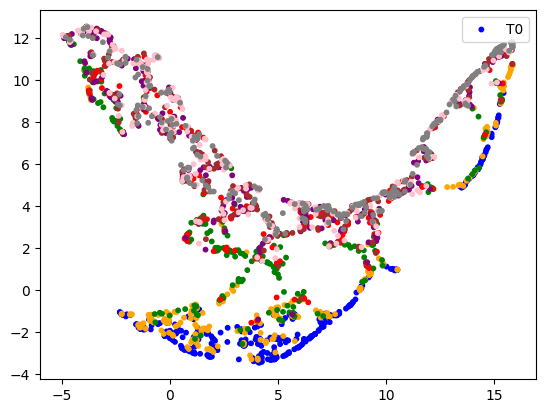

In [34]:
plt.scatter(u[:,0], u[:,1], c=colors, s=10)
plt.legend(['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'])
plt.show()

In [35]:
color_map = {'T0':'blue', 'T1':'orange', 'T2':'green', 'T3':'red', 'T4':'purple', 'T5':'brown', 'T6':'pink', 'T7':'gray'}

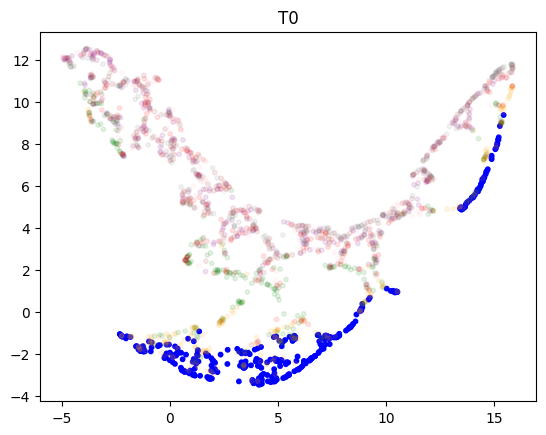

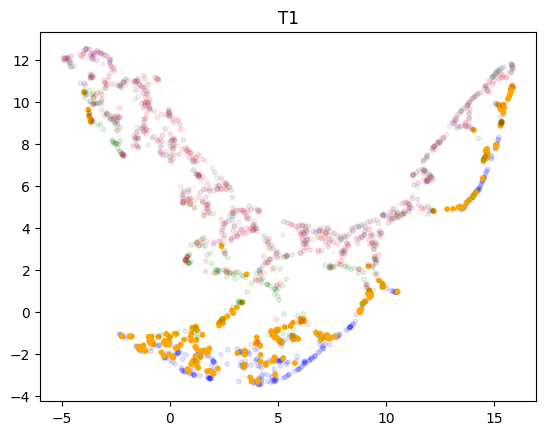

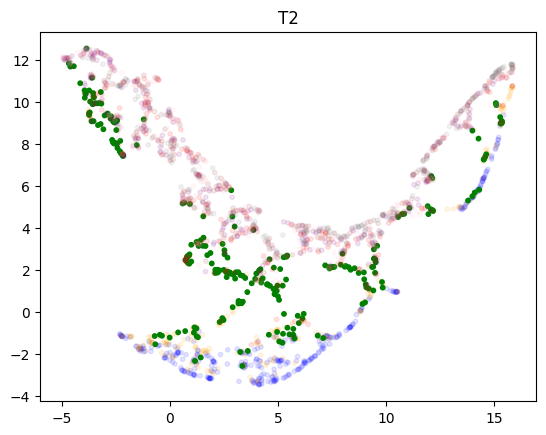

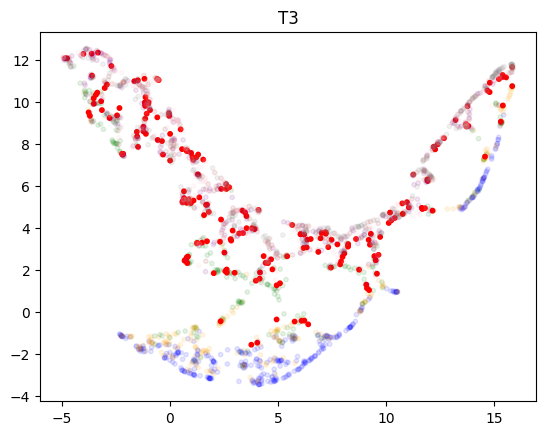

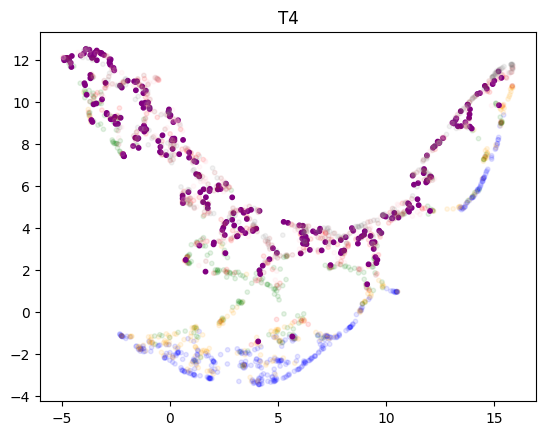

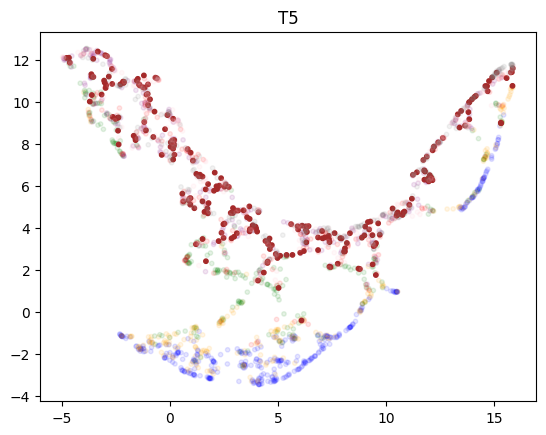

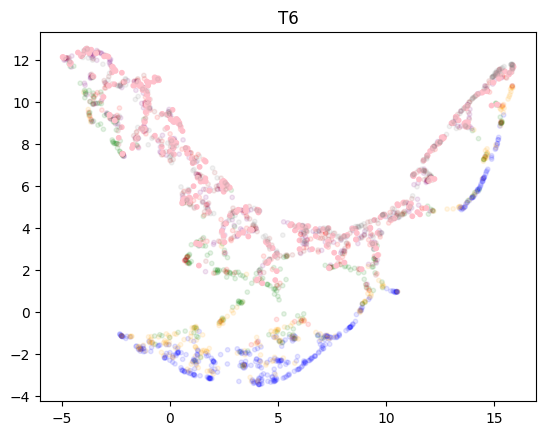

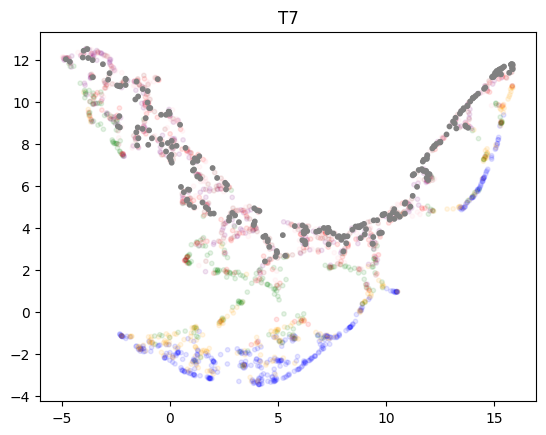

In [36]:
for t1 in timepoints:
    alpha_map = {'T0':0.10, 'T1':0.10, 'T2':0.10, 'T3':0.10, 'T4':0.10, 'T5':0.10, 'T6':0.10, 'T7':0.10}
    alpha_map[t1] = 1.0

    alphas = [
        alpha_map[t]
        for t in timepoints
            for _ in range(t_nodes[t].shape[0])]
    plt.title(t1)
    plt.scatter(u[:,0], u[:,1], c=colors, alpha=alphas, s=10)
    plt.show()
        

In [37]:
from sklearn.cluster import KMeans

In [38]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

nodes_scaled = sc.fit_transform(nodes)

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

x = pca.fit_transform(nodes_scaled)

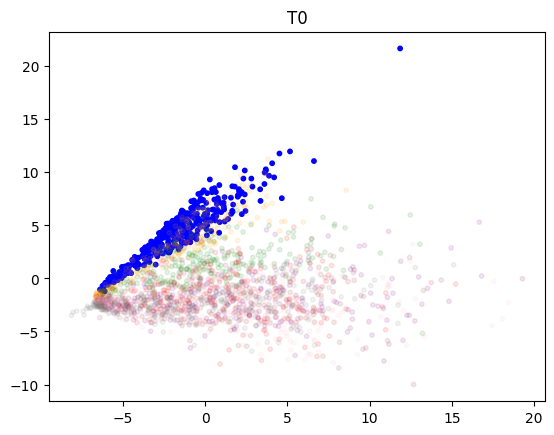

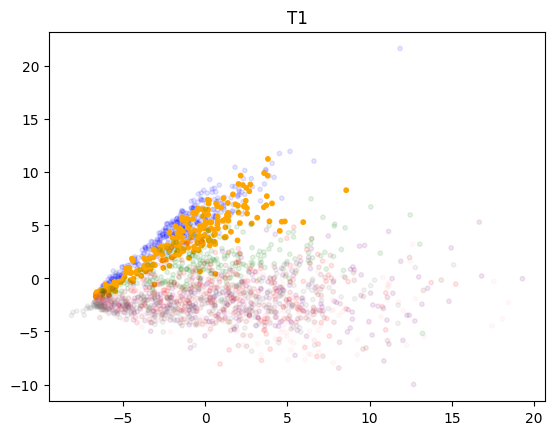

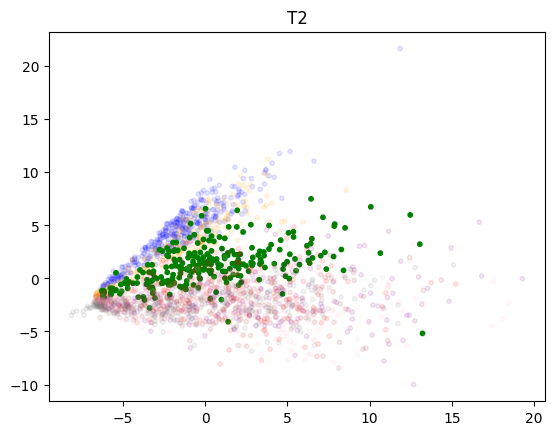

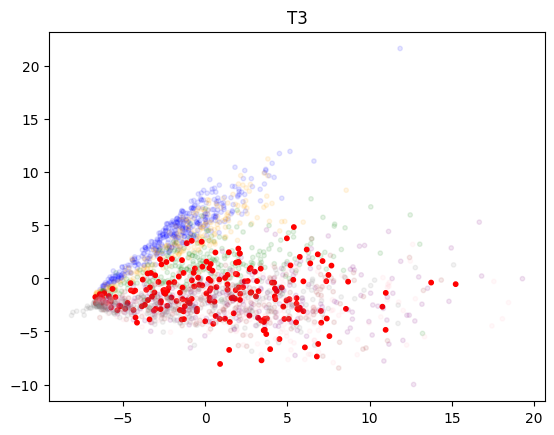

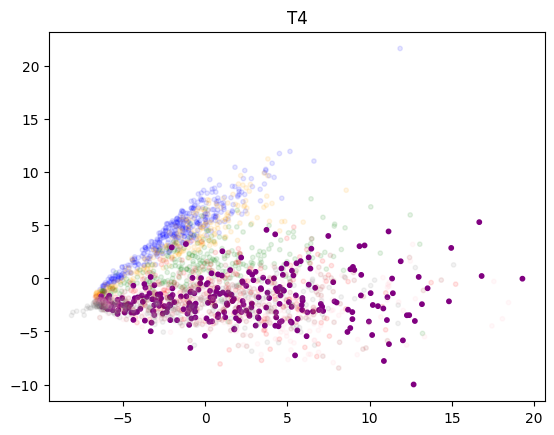

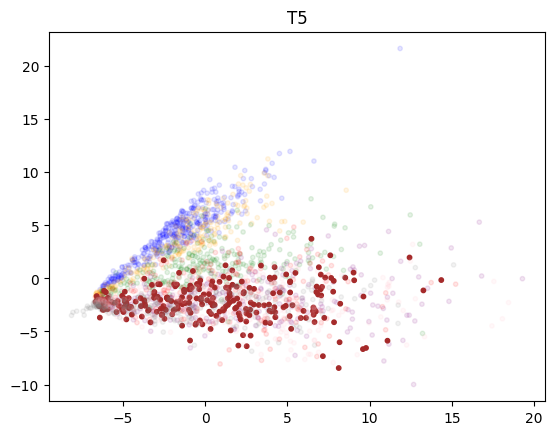

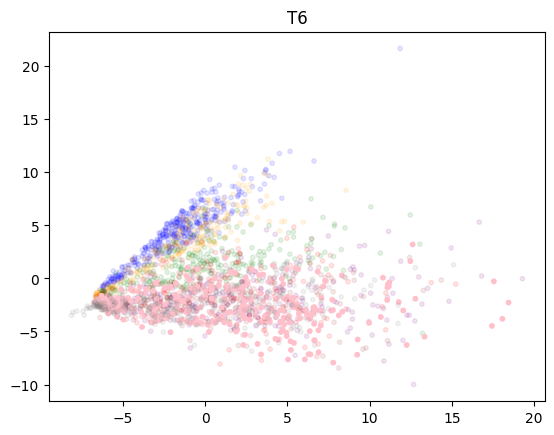

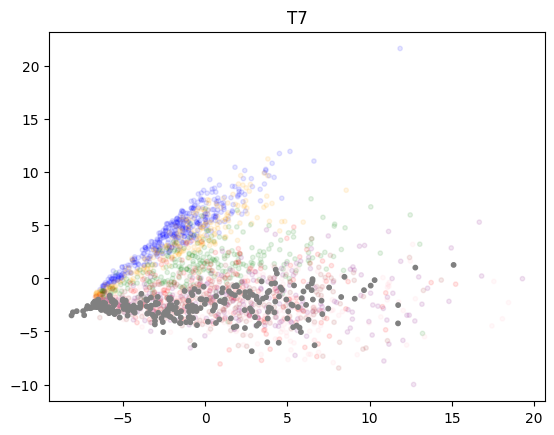

In [40]:
for t1 in timepoints:
    alpha_map = {'T0':0.10, 'T1':0.10, 'T2':0.10, 'T3':0.10, 'T4':0.10, 'T5':0.10, 'T6':0.10, 'T7':0.10}
    alpha_map[t1] = 1.0

    alphas = [
        alpha_map[t]
        for t in timepoints
            for _ in range(t_nodes[t].shape[0])]
    plt.title(t1)
    plt.scatter([i[0] for i in x], [i[1] for i in x], c=colors, alpha=alphas, s=10)
    plt.show()
        
#plt.scatter([i[0] for i in x], [i[1] for i in x], c=colors, s=10)
#plt.show()

/home/neal-kewalramani/.virtualenvs/cont-learn/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


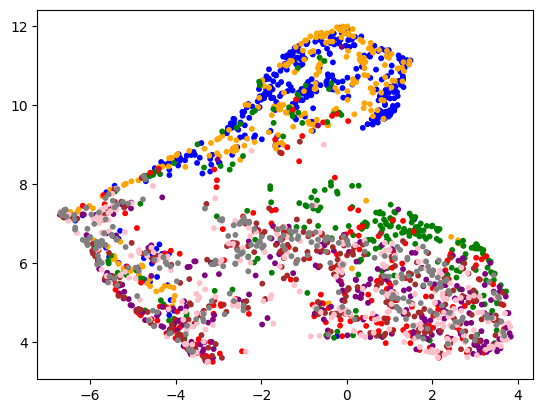

In [41]:
scRNA_vecs = dict()
for t in timepoints:
    scRNA_vecs[t] = np.transpose(scRNA_data.loc[:, [cell for cell in scRNA_data.columns if t in cell]].to_numpy())

nodes = np.vstack(list(scRNA_vecs.values()))
u = fit.fit_transform(nodes)
colors = [
    color_map[t]
    for t in timepoints
        for _ in range(t_nodes[t].shape[0])]

plt.scatter(u[:,0], u[:,1], c=colors, s=10)
#plt.legend(['T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7'])
plt.show()

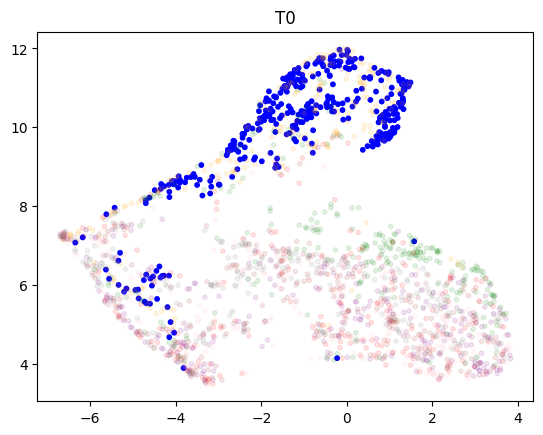

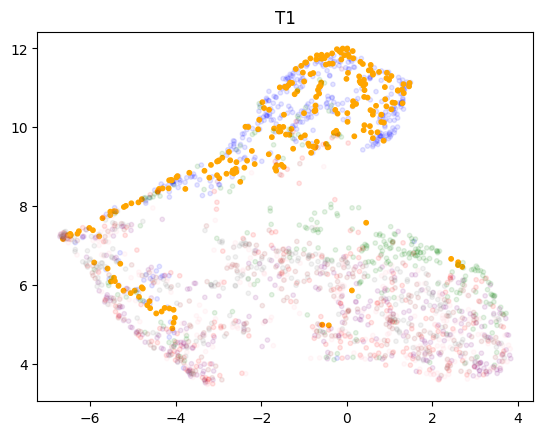

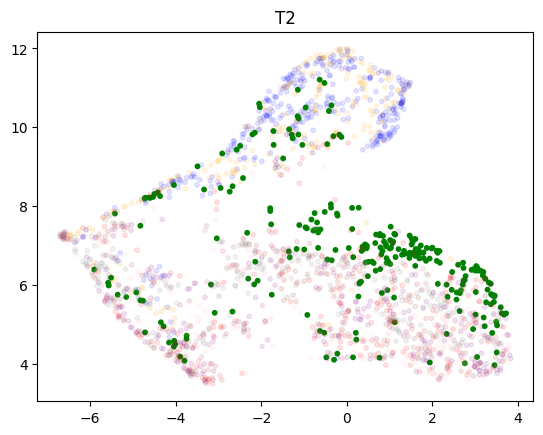

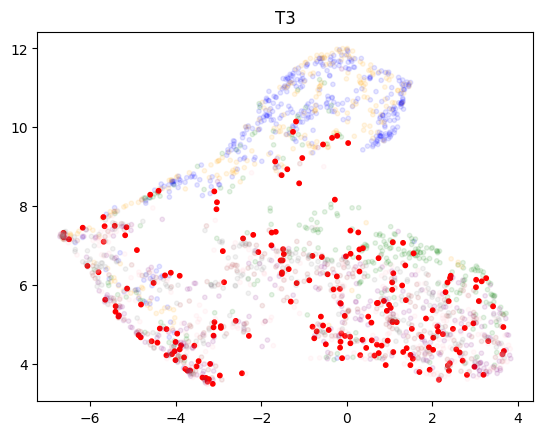

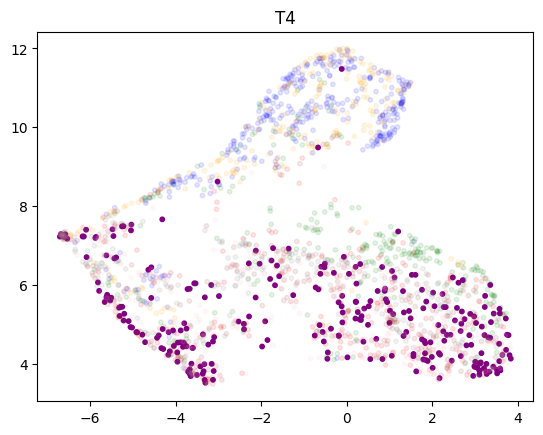

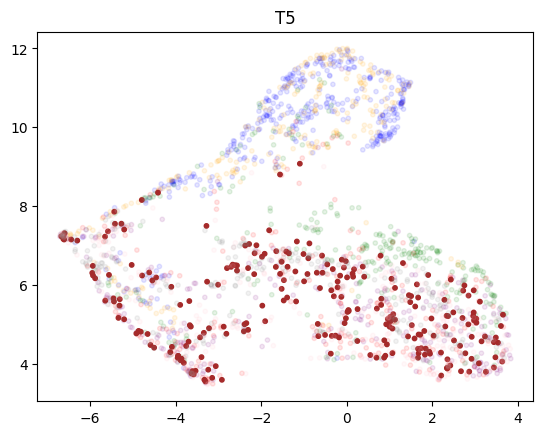

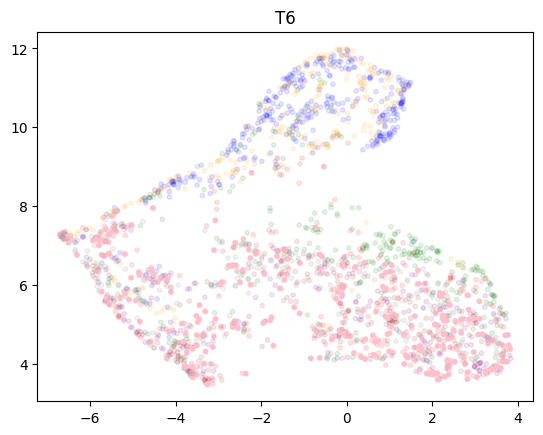

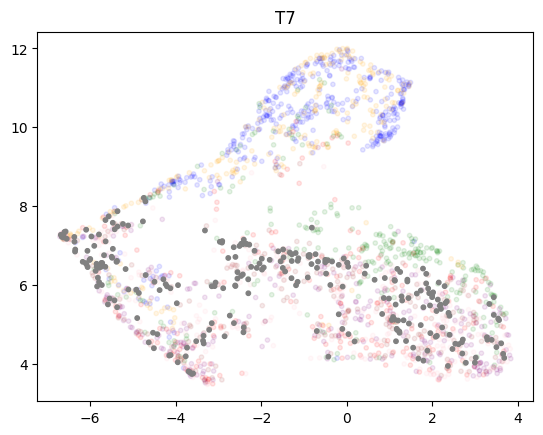

In [42]:
for t1 in timepoints:
    alpha_map = {'T0':0.10, 'T1':0.10, 'T2':0.10, 'T3':0.10, 'T4':0.10, 'T5':0.10, 'T6':0.10, 'T7':0.10}
    alpha_map[t1] = 1.0

    alphas = [
        alpha_map[t]
        for t in timepoints
            for _ in range(t_nodes[t].shape[0])]
    plt.title(t1)
    plt.scatter(u[:,0], u[:,1], c=colors, alpha=alphas, s=10)
    plt.show()
        

# Making Monocle Files

In [43]:
expression_matrix = scRNA_data.to_numpy()
np.savetxt('expression_matrix.txt', expression_matrix)

In [44]:
cell_metadata = dict()
for cell in scRNA_data.columns:
    cell_metadata[cell] = cell.split('_')[1]

cell_metadata = pd.DataFrame(cell_metadata.items(), columns=['cells', 'timepoint'])
cell_metadata = cell_metadata.set_index('cells')
cell_metadata.to_csv('cell_metadata.csv')

In [45]:
gene_attributes = {'gene': list(scRNA_data.index), 'gene_short_name': list(scRNA_data.index)}
gene_attributes = pd.DataFrame(data = gene_attributes)
gene_attributes = gene_attributes.set_index('gene')
gene_attributes.to_csv('gene_attributes.csv')

In [76]:
t_nodes_matrix = np.concatenate([t_nodes[t] for t in timepoints], axis=0).T
t_nodes_index = ['Feature' + str(i) for i in range(t_nodes_matrix.shape[0])]
t_nodes_columns = scRNA_data.columns
t_nodes_df = pd.DataFrame(t_nodes_matrix, columns=t_nodes_columns, index=t_nodes_index)
t_nodes_df.index_name = 'Features'
t_nodes_df.to_csv('expression_matrix_cont.csv')

In [73]:
gene_attributes = {'gene': list(t_nodes_df.index), 'gene_short_name': list(t_nodes_df.index)}
gene_attributes = pd.DataFrame(data = gene_attributes)
gene_attributes = gene_attributes.set_index('gene')
gene_attributes.to_csv('gene_attributes_cont.csv')

In [74]:
gene_attributes

,gene_short_name
gene,
Feature0,Feature0
Feature1,Feature1
Feature2,Feature2
Feature3,Feature3
Feature4,Feature4
...,...
Feature59,Feature59
Feature60,Feature60
Feature61,Feature61


In [75]:
t_nodes_df

,V1_T0,V2_T0,V3_T0,V4_T0,V5_T0,V6_T0,V7_T0,V8_T0,V9_T0,V10_T0,...,V247_T7,V248_T7,V249_T7,V250_T7,V251_T7,V252_T7,V253_T7,V254_T7,V255_T7,V256_T7
Feature0,198.124054,126.501839,123.757515,98.777374,108.600586,106.061539,116.629265,108.012245,111.613228,107.208275,...,2.645660,1.664640,1.151512,1.674802,0.899330,1.876409,1.379242,1.812303,1.458882,1.374802
Feature1,156.084244,90.312813,88.135445,74.865494,77.402504,75.165459,88.475044,80.130127,82.732819,76.497368,...,0.320977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010655,0.000000,0.000000
Feature2,14.535649,46.579315,23.459486,36.805016,39.000267,33.579548,29.627020,31.374336,32.318272,30.764898,...,2.267046,2.015819,1.621196,1.256809,1.643200,1.996203,1.380878,1.938914,1.365785,0.961654
Feature3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Feature4,281.380463,193.128860,178.976685,160.606094,163.000809,158.872452,160.838760,157.608826,158.162796,153.085083,...,4.924331,4.139003,3.404008,3.248845,3.150657,4.319685,3.747601,3.814489,2.940205,2.369663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Feature59,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Feature60,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Feature61,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Feature62,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.981382,2.993625,2.959096,2.546768,2.955538,2.191434,2.170235,1.981566,2.618809,2.333640
